# Introduction
In this notebook we created the model for the Tumor Segmentation.

#Imports:


1.   Torch for model creation



In [1]:
import torch

## UNET
The idea behind a UNET is that we have "Downconvolutions" which are reducing the size of the image combined with increasing filter size followed by "Upconvolutions" which increase the image size up to the original size while reducing the number of filters. <br />
All pairs between Up- and Downconvolutions are linked with skip connections.<br />
Upsampling can either be done by interpolation or by UpConvolutions (ConvTranspose2d)

In [7]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
notebook_dir = Path("/content/drive/MyDrive/Colab Notebooks")  # <-- set to the folder containing your .ipynb
notebook_dir.mkdir(parents=True, exist_ok=True)

import os
os.chdir(notebook_dir)  # now saves go next to the .ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


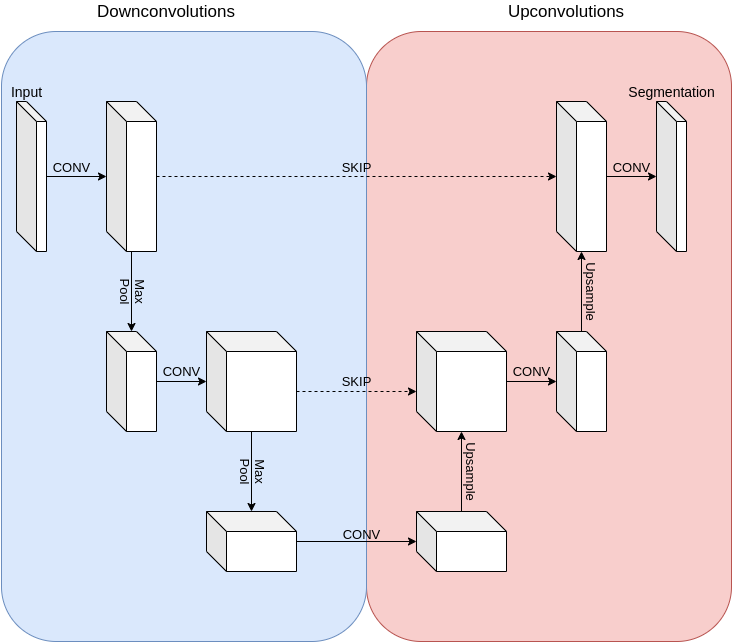

In [8]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Colab Notebooks/unet.png'))

# Convolutions
At first we wrote the class, responsible for the convolutions. We use two convolutions between each down- or upconvolution step.

In [9]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

# U-Net
With the help of DoubleConv we can implement the U-Net by combining DoubleConv with maxpooling for DownConvolutions or DoubleConv with Upsample for UpConv.

In [10]:
class UNet(torch.nn.Module):
    """
    This class implements a UNet for the Segmentation
    We use 3 down- and 3 UpConvolutions and two Convolutions in each step
    """

    def __init__(self):
        """Sets up the U-Net Structure
        """
        super().__init__()


        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 64)  # MRI -> One channel
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)  # Binary label -> One class
        #########################################

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################

        ####### DownConv 2#########
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################

        ##### Intermediate Layer ##
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        #x5 = torch.nn.ConvTranspose2d(512, 512, 2, 2)(x4)
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        #x6 = torch.nn.ConvTranspose2d(256, 256, 2, 2)(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection
        x6 = self.layer6(x6)
        ###########################

        ####### UpCONV 3#########
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        #x7 = torch.nn.ConvTranspose2d(128, 128, 2, 2)(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        ###########################

        ####### Predicted segmentation#########
        ret = self.layer8(x7)
        return ret

#Testing

In [11]:
model = UNet()

In [13]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])